# 자전거 대여량 예측 분석(회귀 문제)

## 파일 로드하기

In [351]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [352]:
bike = pd.read_csv("/content/sample_data/bike_train.csv", sep=",")
bike

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


## 데이터프레임 정보 확인

In [353]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [354]:
bike.shape

(10886, 12)

- 결측값이 없는 걸로 보임
- 하지만, describe()를 통해 자세히 파악하기
- 수치형이 아닌 문자열 자료 1개 존재

In [355]:
bike.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


- 각 feature에 맞게 결측값이 있는 지 파악
- ex) 0이 나오면 안 되는 feature인데 0이 나온 값이 있는 지 여부 파악
- humidity, windspeed 컬럼에 0이 나오면 안 되는 데 min값이 0인 것으로 보아 0으로 적힌 결측값이 있는 걸로 보임

## 데이터 시각화

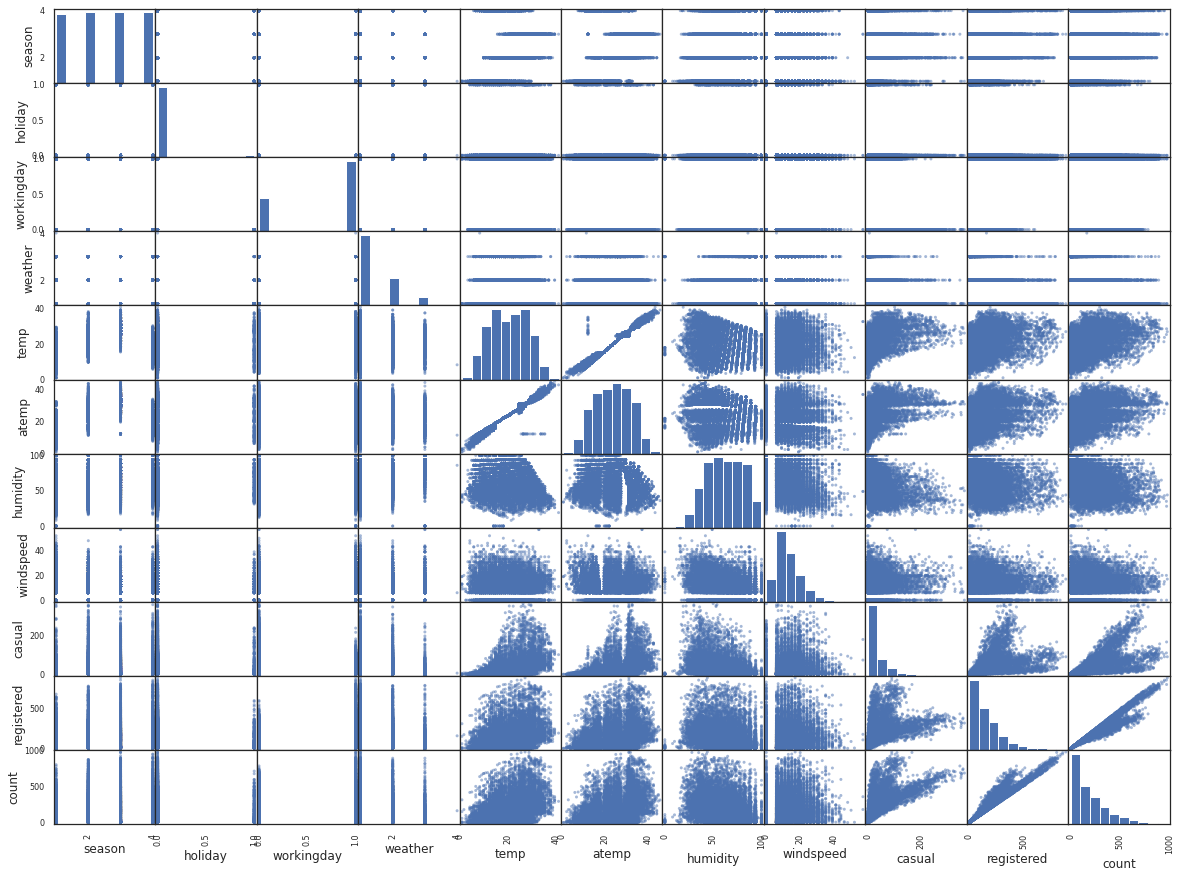

In [356]:
from pandas.plotting import scatter_matrix
scatter_matrix(bike, figsize=(20,15))
plt.show()

산점도를 통한 시각화

앞의 info() 결과에서는 문자열 변수가 datetime만 있었다.

하지만, 지금 시각화 결과를 보니 holiday, workingday, weatherday 변수가 수치형이지만 범주형 변수인 것을 알게 되었다.

## 날짜 데이터프레임으로 변환
- 년도 월 일 시 -> 데이터프레임으로 변환 후 맨 앞에 붙이기
- 요일 컬럼 추가

In [357]:
import datetime
# 년도 월 일 시 요일 데이터프레임 만들기
bike["datetime"] = pd.to_datetime(bike["datetime"], format='%Y-%m-%d %H:%M:%S', errors='raise')
bike["year"] = bike["datetime"].dt.year
bike["month"] = bike["datetime"].dt.month
bike["day"] = bike["datetime"].dt.day
bike["hour"] = bike["datetime"].dt.hour
bike["dayofweek"] = bike["datetime"].dt.dayofweek
bike2 = bike.copy()
bike

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19,2
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20,2
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21,2
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22,2


In [358]:
# 알아보기 쉽게 연도 월 일 시간 요일을 데이터프레임의 제일 왼쪽으로 옮기기
bike = bike.drop(columns=["datetime"])
bike_datetime = bike.iloc[:, 11:]
bike = pd.concat([bike_datetime, bike.iloc[:,:11]], axis=1)
bike

,year,month,day,hour,dayofweek,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011,1,1,0,5,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011,1,1,1,5,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011,1,1,2,5,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011,1,1,3,5,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011,1,1,4,5,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012,12,19,19,2,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012,12,19,20,2,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012,12,19,21,2,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012,12,19,22,2,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


## humidity 컬럼의 결측치 대체하기

In [359]:
bike[bike["humidity"] == 0]

,year,month,day,hour,dayofweek,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
1091,2011,3,10,0,3,1,0,1,3,13.94,15.910,0,16.9979,3,0,3
1092,2011,3,10,1,3,1,0,1,3,13.94,15.910,0,16.9979,0,2,2
1093,2011,3,10,2,3,1,0,1,3,13.94,15.910,0,16.9979,0,1,1
1094,2011,3,10,5,3,1,0,1,3,14.76,17.425,0,12.9980,1,2,3
1095,2011,3,10,6,3,1,0,1,3,14.76,16.665,0,22.0028,0,12,12
1096,2011,3,10,7,3,1,0,1,3,15.58,19.695,0,15.0013,1,36,37
1097,2011,3,10,8,3,1,0,1,3,15.58,19.695,0,19.0012,1,43,44
1098,2011,3,10,9,3,1,0,1,3,16.40,20.455,0,15.0013,1,23,24
1099,2011,3,10,10,3,1,0,1,3,16.40,20.455,0,11.0014,0,17,17
1100,2011,3,10,11,3,1,0,1,3,16.40,20.455,0,16.9979,6,5,11


In [360]:
# humidity 컬럼의 결측값이 0으로 되어있다.
# 또한, 결측값이 모두 다 2011년 3월 10일이므로
# 그 날의 humidity 컬럼의 결측값은
# 2011년 3월 9일과 2011년 3월 11일의 전체 humidity의 평균으로 결측값을 대체하자.
# 그 이유는, 시계열 데이터에서는 가장 가까운 날들의 데이터가 영향을 가장 크게 미치기 때문이다.

In [361]:
hum0309 = bike[(bike["year"] == 2011) & (bike["month"] == 3) & (bike["day"] == 9)].iloc[:, 11].mean()
hum0311 = bike[(bike["year"] == 2011) & (bike["month"] == 3) & (bike["day"] == 11)].iloc[:, 11].mean()
bike["humidity"].replace(0, (hum0309 + hum0311)/2, inplace=True)
bike
# 2011년 3월 10일의 humidity 결측값 대체 완료

,year,month,day,hour,dayofweek,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011,1,1,0,5,1,0,0,1,9.84,14.395,81.0,0.0000,3,13,16
1,2011,1,1,1,5,1,0,0,1,9.02,13.635,80.0,0.0000,8,32,40
2,2011,1,1,2,5,1,0,0,1,9.02,13.635,80.0,0.0000,5,27,32
3,2011,1,1,3,5,1,0,0,1,9.84,14.395,75.0,0.0000,3,10,13
4,2011,1,1,4,5,1,0,0,1,9.84,14.395,75.0,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012,12,19,19,2,4,0,1,1,15.58,19.695,50.0,26.0027,7,329,336
10882,2012,12,19,20,2,4,0,1,1,14.76,17.425,57.0,15.0013,10,231,241
10883,2012,12,19,21,2,4,0,1,1,13.94,15.910,61.0,15.0013,4,164,168
10884,2012,12,19,22,2,4,0,1,1,13.94,17.425,61.0,6.0032,12,117,129


## windspeed 컬럼의 결측치 대체하기(평균값 이용)

In [362]:
bike[bike["windspeed"] == 0]

,year,month,day,hour,dayofweek,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011,1,1,0,5,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16
1,2011,1,1,1,5,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40
2,2011,1,1,2,5,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32
3,2011,1,1,3,5,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13
4,2011,1,1,4,5,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10826,2012,12,17,12,0,4,0,1,2,16.40,20.455,87.0,0.0,21,211,232
10829,2012,12,17,15,0,4,0,1,2,17.22,21.210,88.0,0.0,15,196,211
10846,2012,12,18,8,1,4,0,1,1,15.58,19.695,94.0,0.0,10,652,662
10860,2012,12,18,22,1,4,0,1,1,13.94,16.665,49.0,0.0,5,127,132


In [363]:
# 그런데 windspeed 컬럼의 결측값이 NaN이 아닌 0으로 입력되어있으니
# windspeed 컬럼의 평균값으로 대체해주기 위해
# 0인 값들을 전부 NaN으로 바꿔주자.
bike["windspeed"].replace(0, np.nan, inplace=True)
bike

,year,month,day,hour,dayofweek,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011,1,1,0,5,1,0,0,1,9.84,14.395,81.0,NaN,3,13,16
1,2011,1,1,1,5,1,0,0,1,9.02,13.635,80.0,NaN,8,32,40
2,2011,1,1,2,5,1,0,0,1,9.02,13.635,80.0,NaN,5,27,32
3,2011,1,1,3,5,1,0,0,1,9.84,14.395,75.0,NaN,3,10,13
4,2011,1,1,4,5,1,0,0,1,9.84,14.395,75.0,NaN,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012,12,19,19,2,4,0,1,1,15.58,19.695,50.0,26.0027,7,329,336
10882,2012,12,19,20,2,4,0,1,1,14.76,17.425,57.0,15.0013,10,231,241
10883,2012,12,19,21,2,4,0,1,1,13.94,15.910,61.0,15.0013,4,164,168
10884,2012,12,19,22,2,4,0,1,1,13.94,17.425,61.0,6.0032,12,117,129


In [364]:
bike.info()
# NaN으로 바뀌어서 windspeed 컬럼의 값이 부족한 것을 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        10886 non-null  int64  
 1   month       10886 non-null  int64  
 2   day         10886 non-null  int64  
 3   hour        10886 non-null  int64  
 4   dayofweek   10886 non-null  int64  
 5   season      10886 non-null  int64  
 6   holiday     10886 non-null  int64  
 7   workingday  10886 non-null  int64  
 8   weather     10886 non-null  int64  
 9   temp        10886 non-null  float64
 10  atemp       10886 non-null  float64
 11  humidity    10886 non-null  float64
 12  windspeed   9573 non-null   float64
 13  casual      10886 non-null  int64  
 14  registered  10886 non-null  int64  
 15  count       10886 non-null  int64  
dtypes: float64(4), int64(12)
memory usage: 1.3 MB


In [365]:
bike["windspeed"].values
# 값 확인

array([    nan,     nan,     nan, ..., 15.0013,  6.0032,  8.9981])

In [366]:
# 결측값(NaN)을 평균값으로 대체해주기
# 이 때, 결측값을 가지고 있는 행이 windspeed뿐.

# windspeed 컬럼의 결측값을 평균값으로 대체하는 것! 
bike = bike.fillna(bike.mean())
bike

,year,month,day,hour,dayofweek,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011,1,1,0,5,1,0,0,1,9.84,14.395,81.0,14.554917,3,13,16
1,2011,1,1,1,5,1,0,0,1,9.02,13.635,80.0,14.554917,8,32,40
2,2011,1,1,2,5,1,0,0,1,9.02,13.635,80.0,14.554917,5,27,32
3,2011,1,1,3,5,1,0,0,1,9.84,14.395,75.0,14.554917,3,10,13
4,2011,1,1,4,5,1,0,0,1,9.84,14.395,75.0,14.554917,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012,12,19,19,2,4,0,1,1,15.58,19.695,50.0,26.002700,7,329,336
10882,2012,12,19,20,2,4,0,1,1,14.76,17.425,57.0,15.001300,10,231,241
10883,2012,12,19,21,2,4,0,1,1,13.94,15.910,61.0,15.001300,4,164,168
10884,2012,12,19,22,2,4,0,1,1,13.94,17.425,61.0,6.003200,12,117,129


## 범주형 컬럼 One-hot encoding 필요


In [367]:
# one-hot encoding이 필요한 범주형 컬럼명
features_categoric = ["season", "holiday", "workingday", "weather"]

## 특성 추가
- 불쾌지수 : $\frac{9}{5}temp - 0.55(1-humidity)(\frac{9}{5}temp-26)+32$

In [368]:
from sklearn.base import BaseEstimator, TransformerMixin
# %debug


THI = 9/5*bike["temp"] - 0.55*(1-bike["humidity"]/100)*(9/5*bike["temp"]-26)+32
THI
bike["THI"] = THI
bike5 = bike.copy()
bike

,year,month,day,hour,dayofweek,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,THI
0,2011,1,1,0,5,1,0,0,1,9.84,14.395,81.0,14.554917,3,13,16,50.578096
1,2011,1,1,1,5,1,0,0,1,9.02,13.635,80.0,14.554917,8,32,40,49.310040
2,2011,1,1,2,5,1,0,0,1,9.02,13.635,80.0,14.554917,5,27,32,49.310040
3,2011,1,1,3,5,1,0,0,1,9.84,14.395,75.0,14.554917,3,10,13,50.851600
4,2011,1,1,4,5,1,0,0,1,9.84,14.395,75.0,14.554917,0,1,1,50.851600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012,12,19,19,2,4,0,1,1,15.58,19.695,50.0,26.002700,7,329,336,59.481900
10882,2012,12,19,20,2,4,0,1,1,14.76,17.425,57.0,15.001300,10,231,241,58.433668
10883,2012,12,19,21,2,4,0,1,1,13.94,15.910,61.0,15.001300,4,164,168,57.286766
10884,2012,12,19,22,2,4,0,1,1,13.94,17.425,61.0,6.003200,12,117,129,57.286766


In [369]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


full_pipeline = ColumnTransformer([
                         ("imputer_categoric", OneHotEncoder(), features_categoric),
])

bike_onehot = full_pipeline.fit_transform(bike)
bike_onehot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [370]:
# 범주형 변수 4개 -> one-hot encoding 한 데이터 프레임
bike_onehot = pd.DataFrame(bike_prepared, columns=["season1", "season2", "season3", "season4", "holiday0", "holiday1", "workingday0", "workingday1", "weather1", "weather2", "weather3", "weather4"])
bike_onehot

,season1,season2,season3,season4,holiday0,holiday1,workingday0,workingday1,weather1,weather2,weather3,weather4
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
10882,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
10883,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
10884,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [371]:
# one-hot encoding 한 결과
# 새로운 컬럼으로 붙여주기
bike = pd.concat([bike, bike_onehot], axis=1)
bike = bike.drop(columns=["season", "holiday", "workingday", "weather"])
bike

,year,month,day,hour,dayofweek,temp,atemp,humidity,windspeed,casual,registered,count,THI,season1,season2,season3,season4,holiday0,holiday1,workingday0,workingday1,weather1,weather2,weather3,weather4
0,2011,1,1,0,5,9.84,14.395,81.0,14.554917,3,13,16,50.578096,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2011,1,1,1,5,9.02,13.635,80.0,14.554917,8,32,40,49.310040,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2011,1,1,2,5,9.02,13.635,80.0,14.554917,5,27,32,49.310040,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,2011,1,1,3,5,9.84,14.395,75.0,14.554917,3,10,13,50.851600,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,2011,1,1,4,5,9.84,14.395,75.0,14.554917,0,1,1,50.851600,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012,12,19,19,2,15.58,19.695,50.0,26.002700,7,329,336,59.481900,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
10882,2012,12,19,20,2,14.76,17.425,57.0,15.001300,10,231,241,58.433668,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
10883,2012,12,19,21,2,13.94,15.910,61.0,15.001300,4,164,168,57.286766,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
10884,2012,12,19,22,2,13.94,17.425,61.0,6.003200,12,117,129,57.286766,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


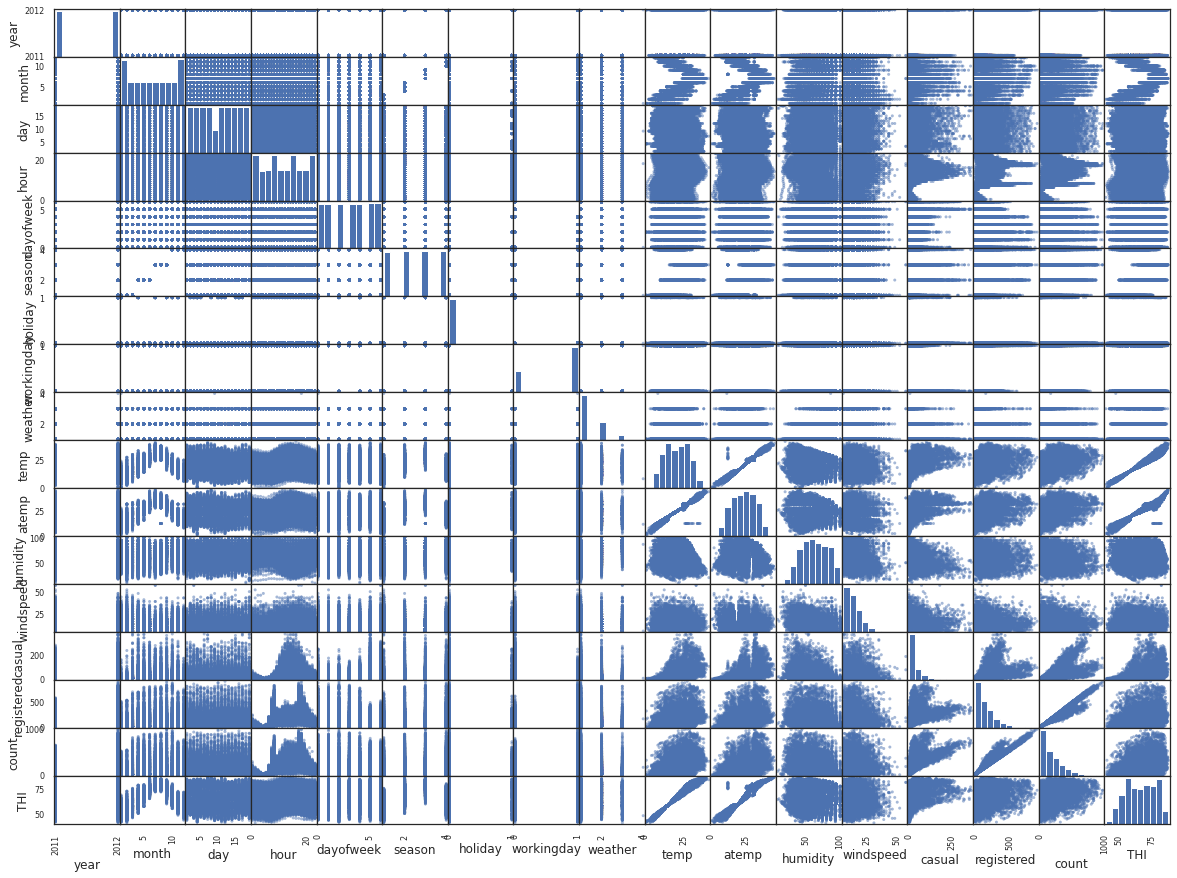

In [372]:
from pandas.plotting import scatter_matrix
scatter_matrix(bike5, figsize=(20, 15))
plt.show()

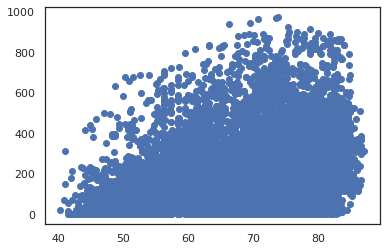

In [373]:
plt.plot(bike["THI"], bike["count"], "bo")
plt.show()
# x축 : THI
# y축 : count

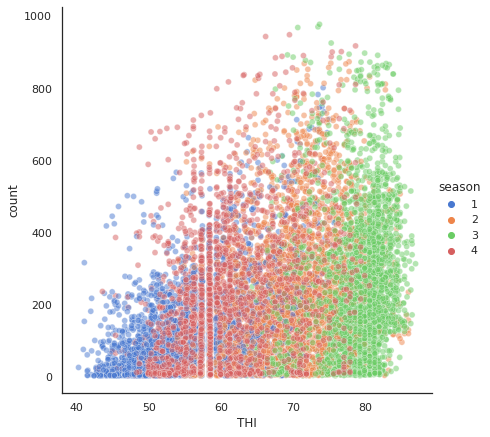

In [374]:
import seaborn as sns
sns.set_theme(style="white")
sns.relplot(x=bike["THI"], y=bike2["count"], hue=bike2["season"], sizes=(40,400), alpha=0.5, palette="muted", height=6, data=bike)
plt.show()

In [375]:
# season : 1-봄, 2-여름, 3-가을, 4-가을
# 인터넷 검색 결과, 여름 가을이 습도가 높은 편(여름이 제일 높음)
# 불쾌 지수는 온도, 습도를 가지고 만든 특성이기 때문에
# 온도, 습도의 영향을 받음

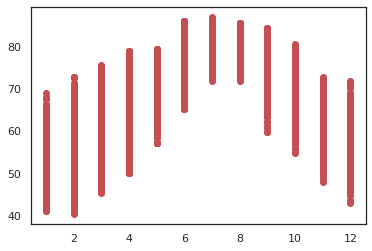

In [376]:
plt.plot(bike["month"], bike["THI"], "ro")
plt.show()
# x축 : month
# y축 : THI
# 월별 불쾌지수 확인

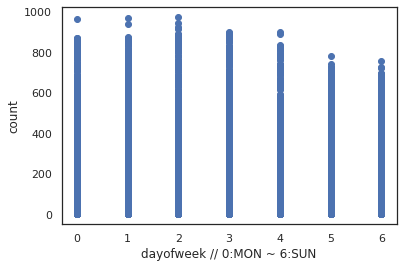

In [377]:
plt.plot(bike["dayofweek"], bike["count"], "bo")
plt.xlabel("dayofweek // 0:MON ~ 6:SUN")
plt.ylabel("count")
plt.show()
# 요일별 총 사용자수 확인 결과
# 주말이 총 사용자수가 가장 낮음

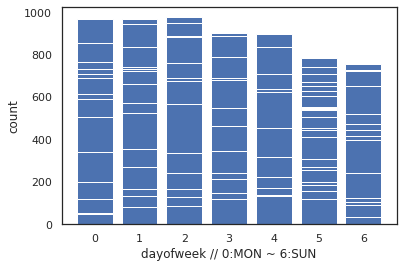

In [378]:
# 요일당 사용자수 히스토그램
plt.bar(bike["dayofweek"], bike["count"])
plt.xlabel("dayofweek // 0:MON ~ 6:SUN")
plt.ylabel("count")
plt.show()
# 상대적으로 주말에 자전거 대여량이 낮음

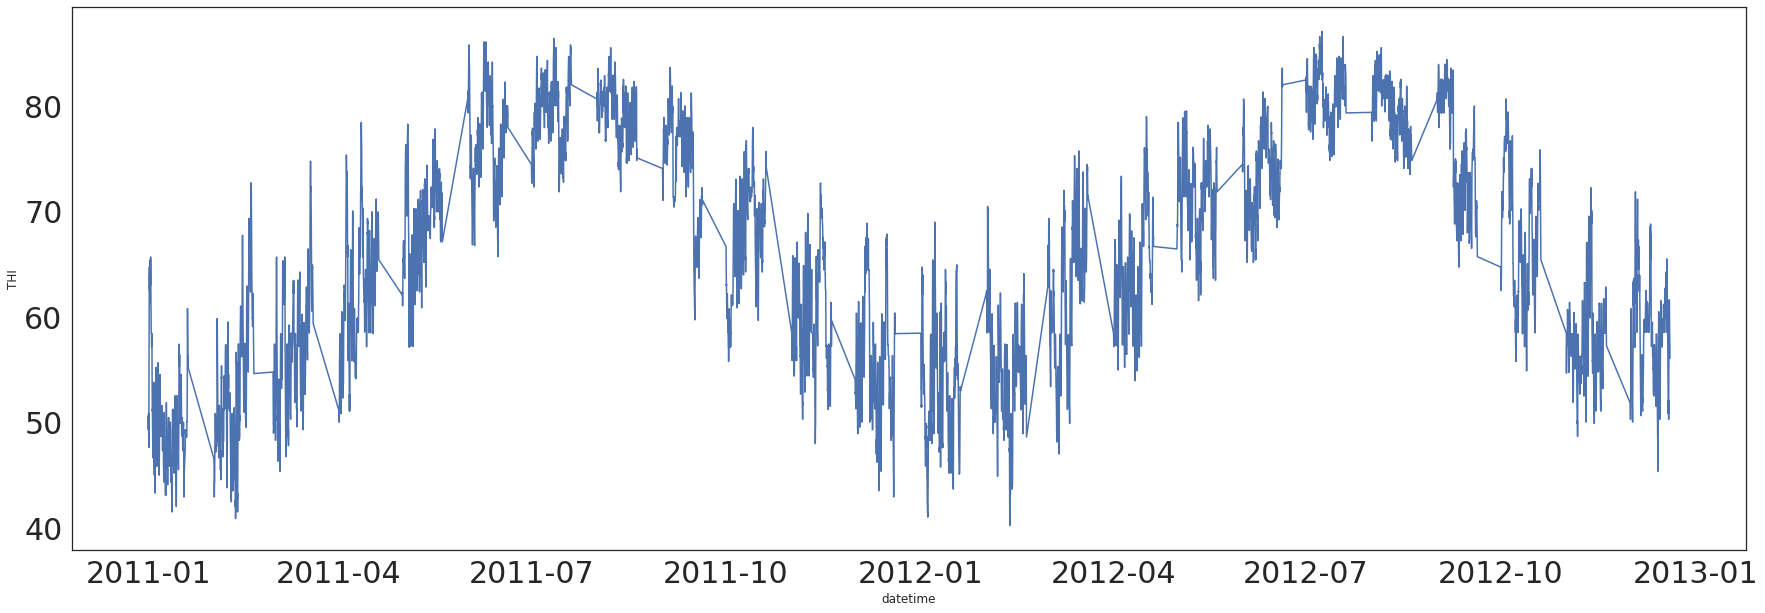

In [394]:
import seaborn as sns
plt.subplots(figsize=(30,10))
a = sns.lineplot(x=bike2["datetime"], y=bike["THI"], data=bike)
a.tick_params(labelsize=30)
plt.show()

In [380]:
# 2011년, 2012년 둘 다
# 여름이 불쾌지수가 가장 높다는 것 시계열 데이터로 확인

# 달별로 갑자기 밑으로 감소하는 직선은
# 지금 train 데이터셋이 매달 1~19일까지밖에 자료가 없기 때문이다.

# 모델링

In [381]:
# 훈련 데이터 / 테스트 데이터로 쪼개기
# 관련 있어 보이는 피쳐만 사용
# 사용할 피쳐 리스트
feature1 = ["year", "month", "day", "hour", "dayofweek", "temp", "atemp", "humidity", "THI", "season1", "season2", "season3", "season4"]
bike3 = bike[feature1]
bike3

,year,month,day,hour,dayofweek,temp,atemp,humidity,THI,season1,season2,season3,season4
0,2011,1,1,0,5,9.84,14.395,81.0,50.578096,1.0,0.0,0.0,0.0
1,2011,1,1,1,5,9.02,13.635,80.0,49.310040,1.0,0.0,0.0,0.0
2,2011,1,1,2,5,9.02,13.635,80.0,49.310040,1.0,0.0,0.0,0.0
3,2011,1,1,3,5,9.84,14.395,75.0,50.851600,1.0,0.0,0.0,0.0
4,2011,1,1,4,5,9.84,14.395,75.0,50.851600,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012,12,19,19,2,15.58,19.695,50.0,59.481900,0.0,0.0,0.0,1.0
10882,2012,12,19,20,2,14.76,17.425,57.0,58.433668,0.0,0.0,0.0,1.0
10883,2012,12,19,21,2,13.94,15.910,61.0,57.286766,0.0,0.0,0.0,1.0
10884,2012,12,19,22,2,13.94,17.425,61.0,57.286766,0.0,0.0,0.0,1.0


In [382]:
# 훈련 데이터 / 테스트 데이터로 쪼개기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bike3, bike["count"], random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8164, 13) (8164,)
(2722, 13) (2722,)


## 1. 랜덤 포레스트

In [383]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=5, random_state=42)


forest.fit(X_train, y_train)
print("훈련 세트 정확도 : {:.3f}".format(forest.score(X_train, y_train)))
print("테스트 세트 정확도 : {:.3f}".format(forest.score(X_test, y_test)))

훈련 세트 정확도 : 0.982
테스트 세트 정확도 : 0.923


In [384]:
# 과적합되었다.

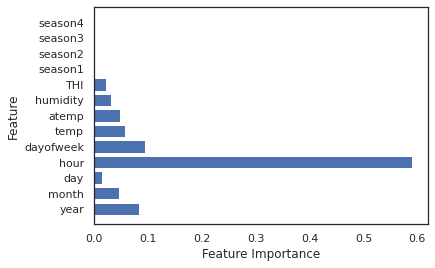

In [385]:
# 특성 중요도 확인
def plot_feature_importances_cancer(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
plot_feature_importances_cancer(forest)
plt.show()

In [386]:
# season 은 4계절의 별 차이가 없는 데
# 차이가 가장 큰 feature는 hour이다.
# 출퇴근 시간과 아닐 때의 자전거 대여량의 차이가 컸다.

# 그래서, 특성 중요도에서 hour 특성의 중요도가 제일 크게 나온 것으로 판단된다.

# 랜덤포레스트 - 그리드 서치

In [387]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# GridSearch
param_grid = [
              {"n_estimators" : [5, 100, 138]},
              
              {"bootstrap" : [False],
               "n_estimators" : [5, 100, 138]}
]

# CrossValidation
# 5-FOLD
grid_search = GridSearchCV(
    RandomForestRegressor(),
    param_grid,
    scoring = "neg_mean_squared_error",
    cv=5,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [388]:
# 최고의 파라미터 조합보기
grid_search.best_params_

{'n_estimators': 138}

In [389]:
# 최고의 파라미터를 이용한 모델 가져오기
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=138, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [390]:
res = grid_search.cv_results_  # Cross Validation 결과 목록 가져오기

for mean_score, params in zip(res["mean_test_score"], res["params"]):
  print(np.sqrt(-mean_score), params)

53.66186210031497 {'n_estimators': 5}
47.67699459040903 {'n_estimators': 100}
47.58908318102115 {'n_estimators': 138}
64.78303621256627 {'bootstrap': False, 'n_estimators': 5}
64.01553783957382 {'bootstrap': False, 'n_estimators': 100}
63.97362296852305 {'bootstrap': False, 'n_estimators': 138}


In [391]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=138, random_state=42)


forest.fit(X_train, y_train)
print("훈련 세트 정확도 : {:.3f}".format(forest.score(X_train, y_train)))
print("테스트 세트 정확도 : {:.3f}".format(forest.score(X_test, y_test)))

훈련 세트 정확도 : 0.991
테스트 세트 정확도 : 0.942


## 2. 그라디언트 부스팅 회귀

In [396]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(random_state=0)
gbrt.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error

y_prediction = gbrt.predict(X_test)
mse = mean_squared_error(y_test, y_prediction)  # mse

rmse = np.sqrt(mse)  # rmse
rmse

69.94613515912506

In [399]:
bike["count"].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

In [400]:
# 평균이 192, 표준편차가 181이고, 최솟값이 1, 최댓값이 977인데
# 오차가 70정도로 나왔으니
# 오차가 작아보인다.

# score를 구해보자.
print("훈련 세트 점수 : {:.3f}".format(gbrt.score(X_train, y_train)))
print("테스트 세트 점수 : {:.3f}".format(gbrt.score(X_test, y_test)))

훈련 세트 점수 : 0.860
테스트 세트 점수 : 0.851
